In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import medmnist
from medmnist import BloodMNIST
from medmnist import INFO
import numpy as np
from PIL import Image
import random

In [77]:
class BloodCellClassifier(nn.Module):
    def __init__(self):
        super(BloodCellClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [78]:
def train_validate(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=10):
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    val_accs = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(num_epochs):
        
        model.train()
        running_train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.append(predicted)
                all_labels.append(labels)

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        all_predictions = torch.cat(all_predictions).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        val_precision = precision_score(all_labels, all_predictions, average='macro')
        val_recall = recall_score(all_labels, all_predictions, average='macro')
        val_f1 = f1_score(all_labels, all_predictions, average='macro')

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f} | "
              f"Val F1: {val_f1:.4f}")

   
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "val_precisions": val_precisions,
        "val_recalls": val_recalls,
        "val_f1s": val_f1s,
    }

In [79]:
num_epochs=20

In [80]:
def plot_val_metrics(metrics):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    epochs = range(1, len(metrics['train_losses']) + 1)

    ax1.plot(epochs, metrics['val_losses'], color='red')
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(epochs, metrics['val_accs'], color='blue')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


## original bloodMNIST dataset

In [81]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset = DataClass(split='train', transform=transforms.ToTensor(), download=True)
valset   = DataClass(split='val', transform=transforms.ToTensor(), download=True)
testset  = DataClass(split='test', transform=transforms.ToTensor(), download=True)

train_dataloader = data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
val_dataloader   = data.DataLoader(dataset=valset, batch_size=128, shuffle=False)
test_dataloader  = data.DataLoader(dataset=testset, batch_size=128, shuffle=False)

def extract_unique_labels(dataset):
    unique_labels = set()
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = int(label[0])
        unique_labels.add(label)
    return sorted(list(unique_labels))

classes = extract_unique_labels(trainset)

label_counts = {}

for data, target in train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

print(f"Train size: {len(trainset)}")
print(f"Validation size: {len(valset)}")
print(f"Test size: {len(testset)}")

Label 7: 1643 images
Label 1: 2181 images
Label 2: 1085 images
Label 0: 852 images
Label 4: 849 images
Label 5: 993 images
Label 3: 2026 images
Label 6: 2330 images
Train size: 11959
Validation size: 1712
Test size: 3421


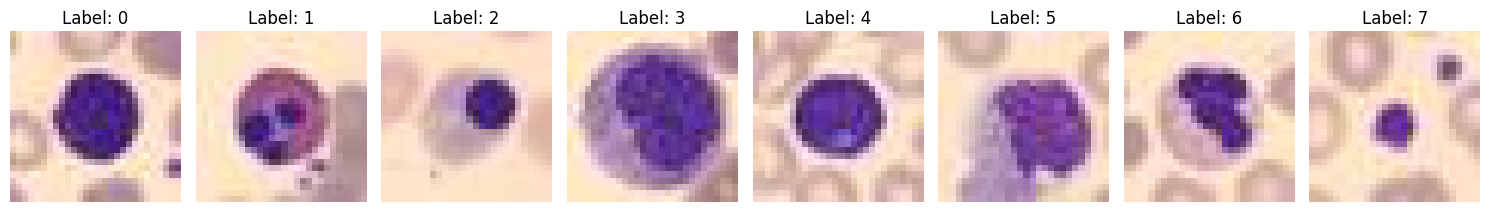

In [82]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(trainset)):
    image, label = trainset[i]

    label = label.item()

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

Epoch 1/20 | Train Loss: 1.3129 | Val Loss: 0.9242 | Val Acc: 62.03% | Val Precision: 0.6916 | Val Recall: 0.5716 | Val F1: 0.5672
Epoch 2/20 | Train Loss: 0.7965 | Val Loss: 0.6850 | Val Acc: 75.93% | Val Precision: 0.7523 | Val Recall: 0.7223 | Val F1: 0.7210
Epoch 3/20 | Train Loss: 0.6295 | Val Loss: 0.5461 | Val Acc: 81.60% | Val Precision: 0.8166 | Val Recall: 0.7693 | Val F1: 0.7720
Epoch 4/20 | Train Loss: 0.5414 | Val Loss: 0.4987 | Val Acc: 81.72% | Val Precision: 0.8320 | Val Recall: 0.7594 | Val F1: 0.7660
Epoch 5/20 | Train Loss: 0.4696 | Val Loss: 0.4224 | Val Acc: 85.34% | Val Precision: 0.8561 | Val Recall: 0.8178 | Val F1: 0.8327
Epoch 6/20 | Train Loss: 0.4271 | Val Loss: 0.3982 | Val Acc: 85.92% | Val Precision: 0.8354 | Val Recall: 0.8468 | Val F1: 0.8358
Epoch 7/20 | Train Loss: 0.3883 | Val Loss: 0.4245 | Val Acc: 84.23% | Val Precision: 0.8436 | Val Recall: 0.8108 | Val F1: 0.8109
Epoch 8/20 | Train Loss: 0.3778 | Val Loss: 0.3446 | Val Acc: 87.79% | Val Precisio

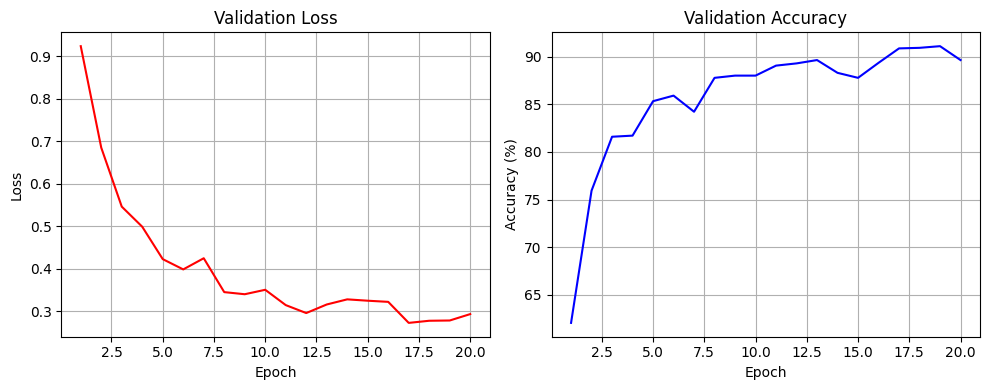

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

original_metrics = train_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(original_metrics)

## generated dataset

In [84]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path)  
        self.labels = np.load(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if image.ndim == 2: 
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [85]:
generated_dataset = GeneratedBloodMNIST(
    data_path='./generated_blood_cell_images1/generated_train_data.npy',
    label_path='./generated_blood_cell_images1/generated_train_labels.npy',
    transform=transforms.ToTensor()
)

total_size = len(generated_dataset)
generated_train_size = int(0.7 * total_size)
generated_val_size = int(0.1 * total_size)
generated_test_size = total_size - generated_train_size - generated_val_size

generated_trainset, generated_valset, generated_testset = random_split(
    generated_dataset,
    [generated_train_size, generated_val_size, generated_test_size],
    generator=torch.Generator().manual_seed(42)
)

generated_train_dataloader = DataLoader(generated_trainset, batch_size=128, shuffle=True)
generated_val_dataloader   = DataLoader(generated_valset, batch_size=128, shuffle=False)
generated_test_dataloader  = DataLoader(generated_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(generated_trainset)}")
print(f"Validation size: {len(generated_valset)}")
print(f"Test size: {len(generated_testset)}")

Train size: 5600
Validation size: 800
Test size: 1600


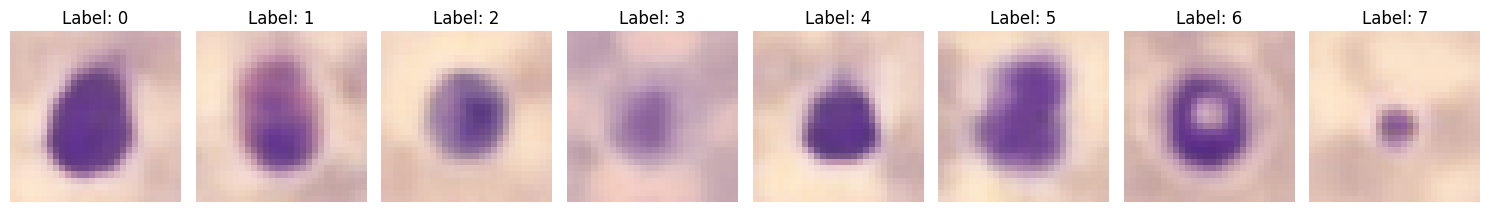

In [86]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(generated_trainset)):
    image, label = generated_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

Epoch 1/20 | Train Loss: 1.5638 | Val Loss: 0.7909 | Val Acc: 77.25% | Val Precision: 0.7985 | Val Recall: 0.7794 | Val F1: 0.7693
Epoch 2/20 | Train Loss: 0.6490 | Val Loss: 0.4812 | Val Acc: 83.00% | Val Precision: 0.8414 | Val Recall: 0.8325 | Val F1: 0.8253
Epoch 3/20 | Train Loss: 0.4719 | Val Loss: 0.4046 | Val Acc: 85.38% | Val Precision: 0.8639 | Val Recall: 0.8567 | Val F1: 0.8549
Epoch 4/20 | Train Loss: 0.4019 | Val Loss: 0.3601 | Val Acc: 86.50% | Val Precision: 0.9041 | Val Recall: 0.8629 | Val F1: 0.8581
Epoch 5/20 | Train Loss: 0.3585 | Val Loss: 0.3190 | Val Acc: 87.38% | Val Precision: 0.8903 | Val Recall: 0.8733 | Val F1: 0.8747
Epoch 6/20 | Train Loss: 0.3008 | Val Loss: 0.2601 | Val Acc: 90.88% | Val Precision: 0.9104 | Val Recall: 0.9112 | Val F1: 0.9102
Epoch 7/20 | Train Loss: 0.2903 | Val Loss: 0.2690 | Val Acc: 90.38% | Val Precision: 0.9020 | Val Recall: 0.9055 | Val F1: 0.9023
Epoch 8/20 | Train Loss: 0.2586 | Val Loss: 0.2475 | Val Acc: 90.88% | Val Precisio

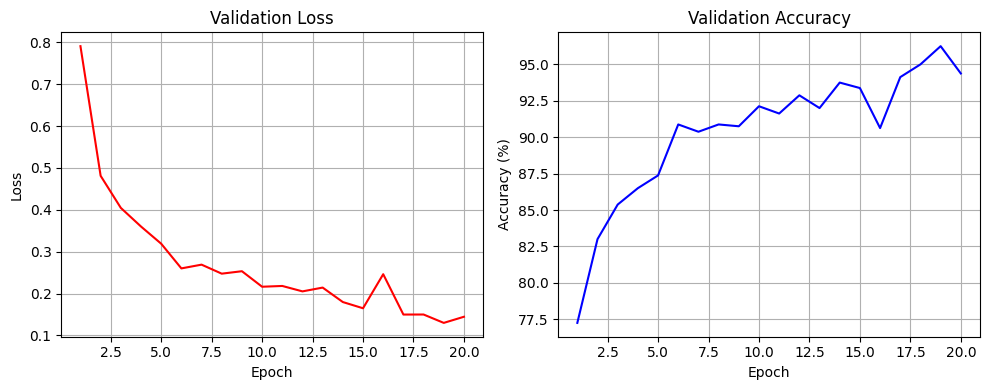

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

generated_metrics = train_validate(
    model=model,
    train_dataloader=generated_train_dataloader,
    val_dataloader=generated_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(generated_metrics)

In [88]:
class FixedBloodMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label

## combined datasets

Epoch 1/20 | Train Loss: 1.2838 | Val Loss: 0.9700 | Val Acc: 62.26% | Val Precision: 0.7092 | Val Recall: 0.6172 | Val F1: 0.5986
Epoch 2/20 | Train Loss: 0.7653 | Val Loss: 0.6914 | Val Acc: 74.96% | Val Precision: 0.7431 | Val Recall: 0.7248 | Val F1: 0.7170
Epoch 3/20 | Train Loss: 0.6140 | Val Loss: 0.5490 | Val Acc: 81.21% | Val Precision: 0.8048 | Val Recall: 0.7997 | Val F1: 0.7982
Epoch 4/20 | Train Loss: 0.5358 | Val Loss: 0.4587 | Val Acc: 84.71% | Val Precision: 0.8320 | Val Recall: 0.8401 | Val F1: 0.8311
Epoch 5/20 | Train Loss: 0.4609 | Val Loss: 0.4348 | Val Acc: 85.03% | Val Precision: 0.8382 | Val Recall: 0.8503 | Val F1: 0.8384
Epoch 6/20 | Train Loss: 0.4055 | Val Loss: 0.3987 | Val Acc: 87.26% | Val Precision: 0.8738 | Val Recall: 0.8653 | Val F1: 0.8669
Epoch 7/20 | Train Loss: 0.3695 | Val Loss: 0.3827 | Val Acc: 86.74% | Val Precision: 0.8702 | Val Recall: 0.8458 | Val F1: 0.8511
Epoch 8/20 | Train Loss: 0.3378 | Val Loss: 0.2955 | Val Acc: 90.76% | Val Precisio

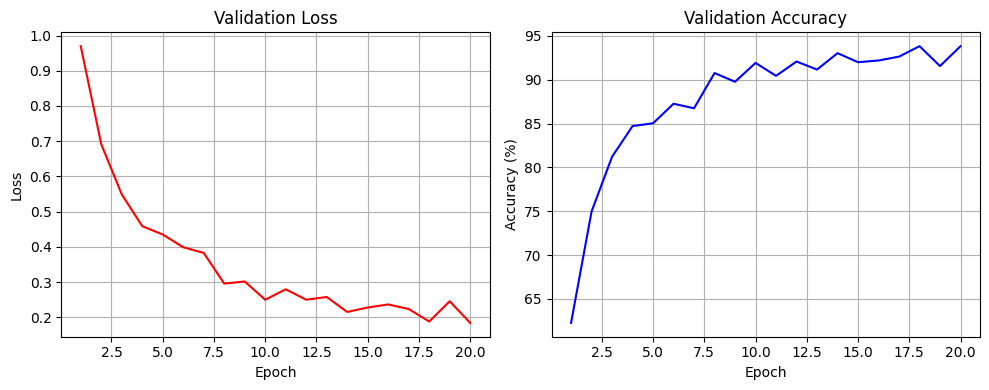

In [89]:
combined_trainset = ConcatDataset([FixedBloodMNIST(trainset), generated_trainset])
combined_valset = ConcatDataset([FixedBloodMNIST(valset), generated_valset])
combined_testset = ConcatDataset([FixedBloodMNIST(testset), generated_testset])

combined_train_loader = DataLoader(combined_trainset, batch_size=128, shuffle=True)
combined_val_dataloader = DataLoader(combined_valset, batch_size=128, shuffle=False)
combined_test_dataloader = DataLoader(combined_testset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

combined_metrics = train_validate(
    model=model,
    train_dataloader=combined_train_loader,
    val_dataloader=combined_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(combined_metrics)

## balanced dataset

In [90]:
def balance_dataset(original_dataset, generated_dataset, target_per_class, classes):

    def indices_by_label(dataset, label):
        return [i for i, (_, lbl) in enumerate(dataset) if int(lbl) == label]

    balanced_indices = []
    combined_dataset = ConcatDataset([original_dataset, generated_dataset])
    offset = len(original_dataset)

    for label in classes:
        original_indices = indices_by_label(original_dataset, label)
        generated_indices = indices_by_label(generated_dataset, label)

        random.shuffle(original_indices)
        random.shuffle(generated_indices)

        total_available = len(original_indices) + len(generated_indices)

        if total_available <= target_per_class:
            chosen_orig = original_indices
            chosen_gen_shifted = [i + offset for i in generated_indices]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)
        else:
            needed_from_gen = target_per_class - len(original_indices)
            needed_from_gen = max(0, needed_from_gen)
            chosen_orig = original_indices[:target_per_class]
            chosen_gen_shifted = [i + offset for i in generated_indices[:needed_from_gen]]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)

    return Subset(combined_dataset, balanced_indices)


In [91]:
target_per_class = 2500

balanced_dataset = balance_dataset(FixedBloodMNIST(ConcatDataset([trainset, valset, testset])), generated_dataset, target_per_class, classes)

balanced_size = len(balanced_dataset)
balanced_train_size = int(0.7 * balanced_size)
balanced_val_size = int(0.1 * balanced_size)
balanced_test_size = balanced_size - balanced_train_size - balanced_val_size

balanced_trainset, balanced_valset, balanced_testset = random_split(
    balanced_dataset,
    [balanced_train_size, balanced_val_size, balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

balanced_train_dataloader = DataLoader(balanced_trainset, batch_size=128, shuffle=True)
balanced_val_dataloader   = DataLoader(balanced_valset, batch_size=128, shuffle=False)
balanced_test_dataloader  = DataLoader(balanced_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(balanced_trainset)}")
print(f"Validation size: {len(balanced_valset)}")
print(f"Test size: {len(balanced_testset)}")

Train size: 13546
Validation size: 1935
Test size: 3871


In [92]:
label_counts = {}

for data, target in balanced_train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')


Label 7: 1784 images
Label 0: 1544 images
Label 5: 1704 images
Label 2: 1774 images
Label 6: 1730 images
Label 4: 1554 images
Label 3: 1749 images
Label 1: 1707 images


Epoch 1/20 | Train Loss: 1.3815 | Val Loss: 0.9810 | Val Acc: 67.39% | Val Precision: 0.6927 | Val Recall: 0.6705 | Val F1: 0.6584
Epoch 2/20 | Train Loss: 0.9265 | Val Loss: 0.7957 | Val Acc: 71.68% | Val Precision: 0.7342 | Val Recall: 0.7146 | Val F1: 0.7128
Epoch 3/20 | Train Loss: 0.7727 | Val Loss: 0.6766 | Val Acc: 75.81% | Val Precision: 0.7812 | Val Recall: 0.7545 | Val F1: 0.7542
Epoch 4/20 | Train Loss: 0.6694 | Val Loss: 0.6048 | Val Acc: 78.91% | Val Precision: 0.7963 | Val Recall: 0.7872 | Val F1: 0.7869
Epoch 5/20 | Train Loss: 0.6085 | Val Loss: 0.5283 | Val Acc: 81.50% | Val Precision: 0.8313 | Val Recall: 0.8098 | Val F1: 0.8114
Epoch 6/20 | Train Loss: 0.5468 | Val Loss: 0.4827 | Val Acc: 83.93% | Val Precision: 0.8423 | Val Recall: 0.8359 | Val F1: 0.8373
Epoch 7/20 | Train Loss: 0.4987 | Val Loss: 0.4992 | Val Acc: 81.50% | Val Precision: 0.8283 | Val Recall: 0.8104 | Val F1: 0.8110
Epoch 8/20 | Train Loss: 0.4495 | Val Loss: 0.4305 | Val Acc: 85.53% | Val Precisio

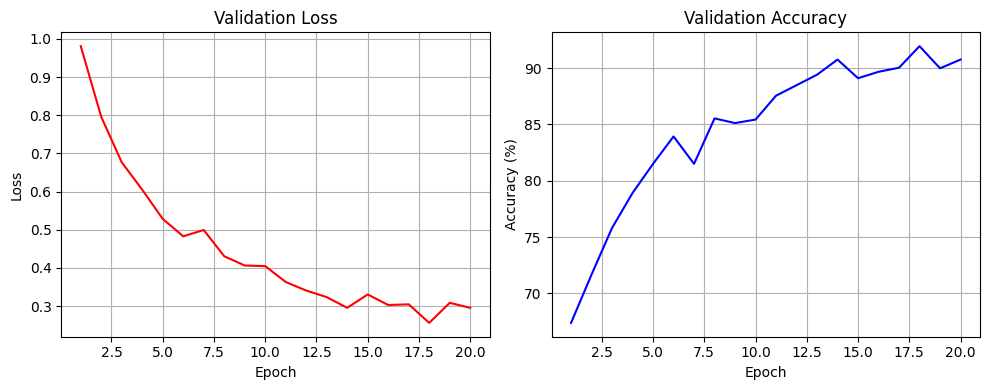

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

balanced_metrics = train_validate(
    model=model,
    train_dataloader=balanced_train_dataloader,
    val_dataloader=balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(balanced_metrics)

## blurred balanced dataset

In [94]:
class BlurredDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label


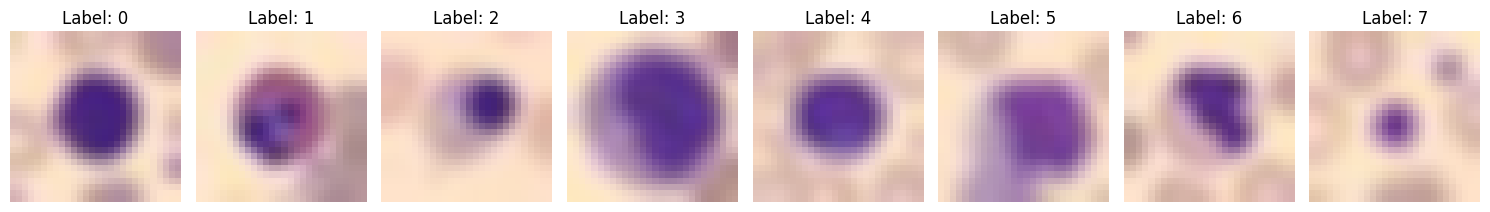

In [95]:
blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=5, sigma=(1, 4.0)),
    transforms.ToTensor()
])

blurred_trainset = BlurredDataset(trainset, blur_transform)
blurred_valset = BlurredDataset(valset, blur_transform)
blurred_testset = BlurredDataset(testset, blur_transform)


plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(blurred_trainset)):
    image, label = blurred_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [96]:
target_per_class = 2500

blurred_balanced_dataset = balance_dataset(ConcatDataset([blurred_trainset, blurred_valset, blurred_testset]), generated_dataset, target_per_class, classes)

blurred_balanced_size = len(blurred_balanced_dataset)
blurred_balanced_train_size = int(0.7 * blurred_balanced_size)
blurred_balanced_val_size = int(0.1 * blurred_balanced_size)
blurred_balanced_test_size = blurred_balanced_size - blurred_balanced_train_size - blurred_balanced_val_size

blurred_balanced_trainset, blurred_balanced_valset, blurred_balanced_testset = random_split(
    blurred_balanced_dataset,
    [blurred_balanced_train_size, blurred_balanced_val_size, blurred_balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

blurred_balanced_train_dataloader = DataLoader(blurred_balanced_trainset, batch_size=128, shuffle=True)
blurred_balanced_val_dataloader   = DataLoader(blurred_balanced_valset, batch_size=128, shuffle=False)
blurred_balanced_test_dataloader  = DataLoader(blurred_balanced_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(blurred_balanced_trainset)}")
print(f"Validation size: {len(blurred_balanced_valset)}")
print(f"Test size: {len(blurred_balanced_testset)}")

label_counts = {}

for data, target in blurred_balanced_train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Train size: 13546
Validation size: 1935
Test size: 3871
Label 2: 1774 images
Label 7: 1784 images
Label 1: 1707 images
Label 3: 1749 images
Label 4: 1554 images
Label 5: 1704 images
Label 6: 1730 images
Label 0: 1544 images


Epoch 1/20 | Train Loss: 1.4017 | Val Loss: 1.1111 | Val Acc: 59.43% | Val Precision: 0.6397 | Val Recall: 0.5895 | Val F1: 0.5872
Epoch 2/20 | Train Loss: 0.9521 | Val Loss: 0.9055 | Val Acc: 65.43% | Val Precision: 0.6859 | Val Recall: 0.6565 | Val F1: 0.6387
Epoch 3/20 | Train Loss: 0.8028 | Val Loss: 0.7615 | Val Acc: 71.68% | Val Precision: 0.7254 | Val Recall: 0.7133 | Val F1: 0.7016
Epoch 4/20 | Train Loss: 0.6818 | Val Loss: 0.7103 | Val Acc: 74.47% | Val Precision: 0.7510 | Val Recall: 0.7388 | Val F1: 0.7344
Epoch 5/20 | Train Loss: 0.6156 | Val Loss: 0.6604 | Val Acc: 76.12% | Val Precision: 0.7707 | Val Recall: 0.7599 | Val F1: 0.7486
Epoch 6/20 | Train Loss: 0.5491 | Val Loss: 0.5677 | Val Acc: 80.72% | Val Precision: 0.8209 | Val Recall: 0.8029 | Val F1: 0.8060
Epoch 7/20 | Train Loss: 0.5035 | Val Loss: 0.5313 | Val Acc: 82.53% | Val Precision: 0.8309 | Val Recall: 0.8249 | Val F1: 0.8236
Epoch 8/20 | Train Loss: 0.4666 | Val Loss: 0.5107 | Val Acc: 82.27% | Val Precisio

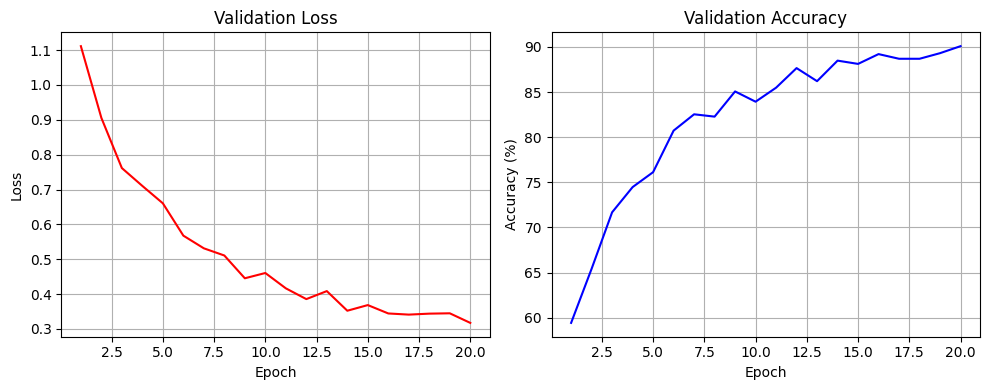

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

blurred_balanced_metrics = train_validate(
    model=model,
    train_dataloader=blurred_balanced_train_dataloader,
    val_dataloader=blurred_balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(blurred_balanced_metrics)

In [103]:
def test_model(model, test_dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_predictions.append(preds)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    cm=confusion_matrix(all_labels, all_predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    

    print(f"Test Accuracy: {accuracy:.4f} | "
            f"Test Precision: {precision:.4f} | "
            f"Test Recall: {recall:.4f} | "
            f"Test F1: {f1:.4f}")

    disp.plot()
    plt.show()

Original dataset
Test Accuracy: 0.7378 | Test Precision: 0.7397 | Test Recall: 0.7507 | Test F1: 0.7183


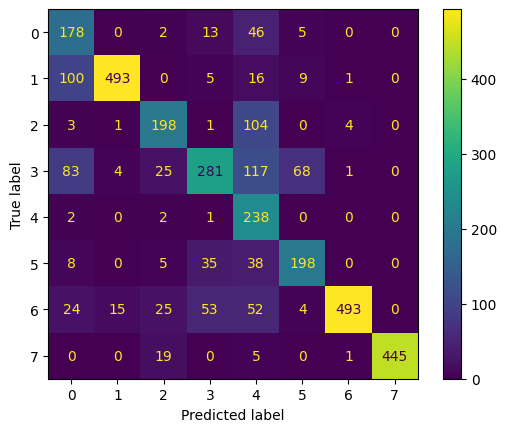

Generated dataset
Test Accuracy: 0.8150 | Test Precision: 0.7302 | Test Recall: 0.8209 | Test F1: 0.7648


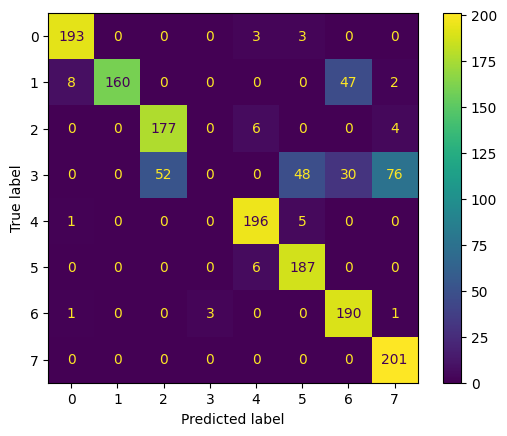

Combined dataset
Test Accuracy: 0.7624 | Test Precision: 0.7599 | Test Recall: 0.7829 | Test F1: 0.7512


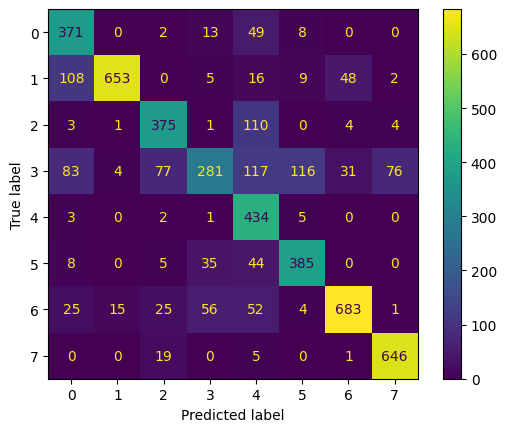

Balanced dataset
Test Accuracy: 0.7959 | Test Precision: 0.8222 | Test Recall: 0.7994 | Test F1: 0.7969


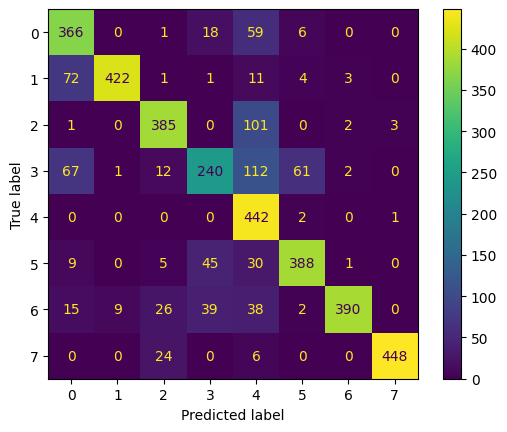

Blurred balanced dataset
Test Accuracy: 0.8874 | Test Precision: 0.8948 | Test Recall: 0.8868 | Test F1: 0.8885


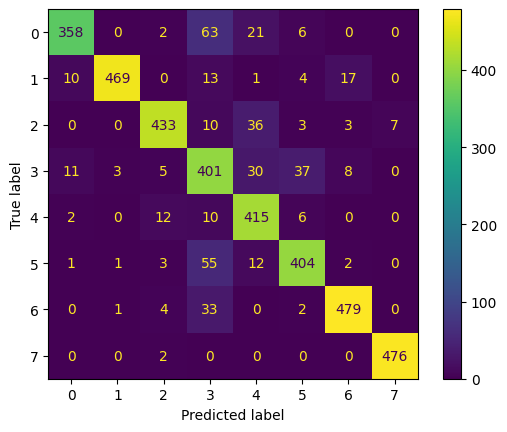

In [104]:
print("Original dataset")
test_model(model=model, test_dataloader=test_dataloader, device=device)

print("Generated dataset")
test_model(model=model, test_dataloader=generated_test_dataloader, device=device)

print("Combined dataset")
test_model(model=model, test_dataloader=combined_test_dataloader, device=device)

print("Balanced dataset")
test_model(model=model, test_dataloader=balanced_test_dataloader, device=device)

print("Blurred balanced dataset")
test_model(model=model, test_dataloader=blurred_balanced_test_dataloader, device=device)